# 03 - EDA - Exploratory Data Analysis

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#notebook settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
data = pd.read_csv(os.path.join('..','data','processed','prepared_football_data.csv'))

data_for_back_testing = data[['implied_home_win_prob','implied_draw_prob','implied_away_win_prob']]

# removing the implied probabilities, this is only nedded for backtesting
data = data.drop(columns=['implied_home_win_prob','implied_draw_prob','implied_away_win_prob'])

print(data.shape)

data.head()

(7389, 95)


,home_team,away_team,full_time_result,day_of_week,month,day_of_week_sin,day_of_week_cos,month_sin,month_cos,home_roll_3_avg_home_total_goals,away_roll_3_avg_home_total_goals,home_roll_3_avg_away_total_goals,away_roll_3_avg_away_total_goals,home_roll_3_avg_home_total_shots,away_roll_3_avg_home_total_shots,home_roll_3_avg_away_total_shots,away_roll_3_avg_away_total_shots,home_roll_3_avg_home_shots_on_target,away_roll_3_avg_home_shots_on_target,home_roll_3_avg_away_shots_on_target,away_roll_3_avg_away_shots_on_target,home_roll_3_avg_home_fouls,away_roll_3_avg_home_fouls,home_roll_3_avg_away_fouls,away_roll_3_avg_away_fouls,home_roll_3_avg_home_corners,away_roll_3_avg_home_corners,home_roll_3_avg_away_corners,away_roll_3_avg_away_corners,home_roll_3_avg_home_yellow_cards,away_roll_3_avg_home_yellow_cards,home_roll_3_avg_away_yellow_cards,away_roll_3_avg_away_yellow_cards,home_roll_3_avg_home_red_cards,away_roll_3_avg_home_red_cards,home_roll_3_avg_away_red_cards,away_roll_3_avg_away_red_cards,home_roll_3_avg_home_shot_accuracy,away_roll_3_avg_home_shot_accuracy,home_roll_3_avg_away_shot_accuracy,away_roll_3_avg_away_shot_accuracy,home_roll_3_avg_ratio_h_a_shots,away_roll_3_avg_ratio_h_a_shots,home_roll_3_avg_ratio_h_a_fouls,away_roll_3_avg_ratio_h_a_fouls,home_roll_3_avg_ratio_a_h_shots,away_roll_3_avg_ratio_a_h_shots,home_roll_3_avg_ratio_a_h_fouls,away_roll_3_avg_ratio_a_h_fouls,home_roll_3_avg_goal_difference,away_roll_3_avg_goal_difference,home_roll_5_avg_home_total_goals,away_roll_5_avg_home_total_goals,home_roll_5_avg_away_total_goals,away_roll_5_avg_away_total_goals,home_roll_5_avg_home_total_shots,away_roll_5_avg_home_total_shots,home_roll_5_avg_away_total_shots,away_roll_5_avg_away_total_shots,home_roll_5_avg_home_shots_on_target,away_roll_5_avg_home_shots_on_target,home_roll_5_avg_away_shots_on_target,away_roll_5_avg_away_shots_on_target,home_roll_5_avg_home_fouls,away_roll_5_avg_home_fouls,home_roll_5_avg_away_fouls,away_roll_5_avg_away_fouls,home_roll_5_avg_home_corners,away_roll_5_avg_home_corners,home_roll_5_avg_away_corners,away_roll_5_avg_away_corners,home_roll_5_avg_home_yellow_cards,away_roll_5_avg_home_yellow_cards,home_roll_5_avg_away_yellow_cards,away_roll_5_avg_away_yellow_cards,home_roll_5_avg_home_red_cards,away_roll_5_avg_home_red_cards,home_roll_5_avg_away_red_cards,away_roll_5_avg_away_red_cards,home_roll_5_avg_home_shot_accuracy,away_roll_5_avg_home_shot_accuracy,home_roll_5_avg_away_shot_accuracy,away_roll_5_avg_away_shot_accuracy,home_roll_5_avg_ratio_h_a_shots,away_roll_5_avg_ratio_h_a_shots,home_roll_5_avg_ratio_h_a_fouls,away_roll_5_avg_ratio_h_a_fouls,home_roll_5_avg_ratio_a_h_shots,away_roll_5_avg_ratio_a_h_shots,home_roll_5_avg_ratio_a_h_fouls,away_roll_5_avg_ratio_a_h_fouls,home_roll_5_avg_goal_difference,away_roll_5_avg_goal_difference,home_cumulative_points,away_cumulative_points
0,aston villa,bolton,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,everton,man united,A,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3
2,fulham,birmingham,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## Dtypes, Missing, Values, Duplicates, ...

In [4]:
data.dtypes.value_counts()

float64    88
int64       4
object      3
Name: count, dtype: int64

In [5]:
def check_data(data):
    data_check = pd.DataFrame()
    data_check['Data Types'] = data.dtypes
    data_check['Missing Values'] = data.isnull().sum()
    data_check['Unique Values'] = data.nunique()
    data_check['Duplicates'] = [data.duplicated().sum()] + [None] * (data.shape[1] - 1)

    # Calculate outliers using z-score approach
    def detect_outliers(column):
        if np.issubdtype(column.dtype, np.number):  # Only apply to numeric columns
            z_scores = (column - column.mean()) / column.std()
            return ((z_scores.abs() > 3).sum())
        return None  # Return None for non-numeric columns
    
    data_check['Outliers (Z>3)'] = data.apply(detect_outliers)
    
    # Add basic statistics for numeric columns
    data_check['Mean'] = data.select_dtypes(include=[np.number]).mean()
    data_check['Median'] = data.select_dtypes(include=[np.number]).median()
    data_check['Min'] = data.select_dtypes(include=[np.number]).min()
    data_check['Max'] = data.select_dtypes(include=[np.number]).max()
    
    # Shape of the dataset
    data_check.loc['Shape'] = [''] * len(data_check.columns)
    data_check.loc['Shape', 'Data Types'] = f"Rows: {data.shape[0]}, Columns: {data.shape[1]}"
    
    return data_check

check_data(data).head()

,Data Types,Missing Values,Unique Values,Duplicates,Outliers (Z>3),Mean,Median,Min,Max
home_team,object,0,44,16.0,NaN,NaN,NaN,NaN,NaN
away_team,object,0,44,NaN,NaN,NaN,NaN,NaN,NaN
full_time_result,object,0,3,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,int64,0,7,NaN,0.0,4.469617,5.0,0.0,6.0
month,int64,0,12,NaN,0.0,6.775206,8.0,1.0,12.0


## Correlations

In [6]:
# We'll use correlation matrix to identify highly correlated features

# Select only numerical features
numerical_data = data.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numerical_data.corr()

threshold = 0.8

# Get the correlation matrix and filter for correlations above the threshold
high_corr_pairs = corr_matrix.where((corr_matrix.abs() > threshold) & (corr_matrix != 1))

# Drop NA values for a cleaner view
high_corr_pairs = high_corr_pairs.stack().reset_index()
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

high_corr_pairs.head(15)

print(f"we have {high_corr_pairs.shape[0]} pairs of highly correlated features")

we have 254 pairs of highly correlated features


## Target Distribution

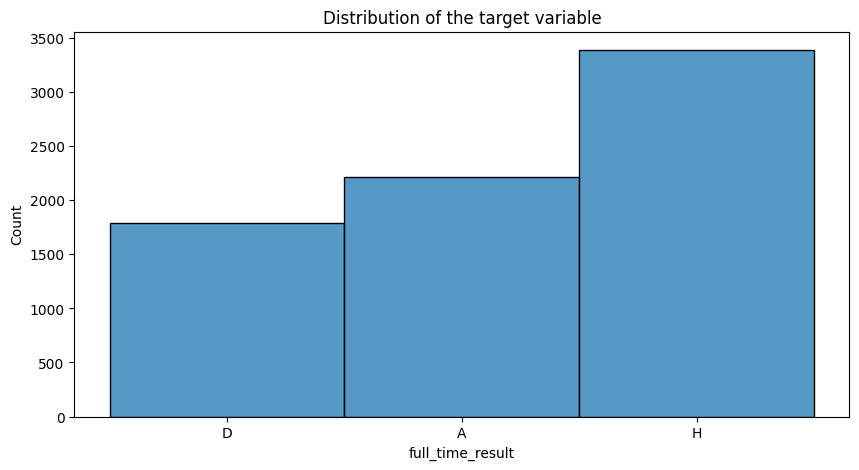

In [7]:
# show the distribution of the target variable
plt.figure(figsize=(10,5))
sns.histplot(data['full_time_result'])
plt.title('Distribution of the target variable')
plt.show()

In [9]:
print(data.shape)

data.head()

(7389, 95)


,home_team,away_team,full_time_result,day_of_week,month,day_of_week_sin,day_of_week_cos,month_sin,month_cos,home_roll_3_avg_home_total_goals,away_roll_3_avg_home_total_goals,home_roll_3_avg_away_total_goals,away_roll_3_avg_away_total_goals,home_roll_3_avg_home_total_shots,away_roll_3_avg_home_total_shots,home_roll_3_avg_away_total_shots,away_roll_3_avg_away_total_shots,home_roll_3_avg_home_shots_on_target,away_roll_3_avg_home_shots_on_target,home_roll_3_avg_away_shots_on_target,away_roll_3_avg_away_shots_on_target,home_roll_3_avg_home_fouls,away_roll_3_avg_home_fouls,home_roll_3_avg_away_fouls,away_roll_3_avg_away_fouls,home_roll_3_avg_home_corners,away_roll_3_avg_home_corners,home_roll_3_avg_away_corners,away_roll_3_avg_away_corners,home_roll_3_avg_home_yellow_cards,away_roll_3_avg_home_yellow_cards,home_roll_3_avg_away_yellow_cards,away_roll_3_avg_away_yellow_cards,home_roll_3_avg_home_red_cards,away_roll_3_avg_home_red_cards,home_roll_3_avg_away_red_cards,away_roll_3_avg_away_red_cards,home_roll_3_avg_home_shot_accuracy,away_roll_3_avg_home_shot_accuracy,home_roll_3_avg_away_shot_accuracy,away_roll_3_avg_away_shot_accuracy,home_roll_3_avg_ratio_h_a_shots,away_roll_3_avg_ratio_h_a_shots,home_roll_3_avg_ratio_h_a_fouls,away_roll_3_avg_ratio_h_a_fouls,home_roll_3_avg_ratio_a_h_shots,away_roll_3_avg_ratio_a_h_shots,home_roll_3_avg_ratio_a_h_fouls,away_roll_3_avg_ratio_a_h_fouls,home_roll_3_avg_goal_difference,away_roll_3_avg_goal_difference,home_roll_5_avg_home_total_goals,away_roll_5_avg_home_total_goals,home_roll_5_avg_away_total_goals,away_roll_5_avg_away_total_goals,home_roll_5_avg_home_total_shots,away_roll_5_avg_home_total_shots,home_roll_5_avg_away_total_shots,away_roll_5_avg_away_total_shots,home_roll_5_avg_home_shots_on_target,away_roll_5_avg_home_shots_on_target,home_roll_5_avg_away_shots_on_target,away_roll_5_avg_away_shots_on_target,home_roll_5_avg_home_fouls,away_roll_5_avg_home_fouls,home_roll_5_avg_away_fouls,away_roll_5_avg_away_fouls,home_roll_5_avg_home_corners,away_roll_5_avg_home_corners,home_roll_5_avg_away_corners,away_roll_5_avg_away_corners,home_roll_5_avg_home_yellow_cards,away_roll_5_avg_home_yellow_cards,home_roll_5_avg_away_yellow_cards,away_roll_5_avg_away_yellow_cards,home_roll_5_avg_home_red_cards,away_roll_5_avg_home_red_cards,home_roll_5_avg_away_red_cards,away_roll_5_avg_away_red_cards,home_roll_5_avg_home_shot_accuracy,away_roll_5_avg_home_shot_accuracy,home_roll_5_avg_away_shot_accuracy,away_roll_5_avg_away_shot_accuracy,home_roll_5_avg_ratio_h_a_shots,away_roll_5_avg_ratio_h_a_shots,home_roll_5_avg_ratio_h_a_fouls,away_roll_5_avg_ratio_h_a_fouls,home_roll_5_avg_ratio_a_h_shots,away_roll_5_avg_ratio_a_h_shots,home_roll_5_avg_ratio_a_h_fouls,away_roll_5_avg_ratio_a_h_fouls,home_roll_5_avg_goal_difference,away_roll_5_avg_goal_difference,home_cumulative_points,away_cumulative_points
0,aston villa,bolton,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,everton,man united,A,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3
2,fulham,birmingham,D,5,8,-0.866025,0.5,-0.866025,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [10]:
# save the data
data.to_csv(os.path.join('..','data','processed','data_for_model.csv'), index=False)
data_for_back_testing.to_csv(os.path.join('..','data','processed','data_for_back_testing.csv'), index=False)